In [2]:
## Building an S3 Compliant Stock Market Data Lake with MinIO
## https://blog.min.io/building-an-s3-compliant-stock-market-data-lake-with-minio/

In [2]:
# installing the require pakages 

!pip install matplotlib
!pip install s3fs
!pip install seaborn
!pip install yfinance

  Using cached contourpy-1.2.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 949.7 kB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_10_9_x86_64.whl.metadata (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached pillow-10.2.0-cp39-cp39-macosx_10_10_x86_64.whl.metadata (9.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 2.0 MB/s eta 0:00:0000:0100:01
Using cached contourpy-1.2.0-cp39-cp39-macosx_10_9_x86_64.whl (257 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.3 MB/s eta 0:00:0000:0100:010m
Using cached kiwisolver-1.4.5-cp39-cp39-macosx_10_9_x86_64.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 2.9 MB/s eta 0:00:0000:0100:01
Using cached pillow-10.2.0-cp39-cp39-macosx_10_10_x86_

In [4]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 1.9 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [6]:
import datetime
import os

import yfinance as yf

start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)
download_dir = os.path.join(os.getcwd(), 'marketdata')

magnificient_seven = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

for ticker_string in magnificient_seven:
   ticker = yf.Ticker(ticker_string)
   historical_data = ticker.history(start=start_date, end=end_date)
   file_path = os.path.join(download_dir, f'{ticker_string}.parquet')
   historical_data.to_parquet(file_path)
   print(f'{ticker_string} downloaded.')

AAPL downloaded.
AMZN downloaded.
GOOGL downloaded.
META downloaded.
MSFT downloaded.
NVDA downloaded.
TSLA downloaded.


In [7]:
# Setting up an S3 Connection

In [26]:
from s3fs import S3FileSystem

# Pease do not include secret key and access token in your code... this is for demostration only and the key & secret will be discarded.
# use vault or any secret manager to store and read secret

key = 'Is4MNdgVpvEwHeNn'
secret = 'zX2cFDClAIfl8Ecbz96I2J9QGTLUjaEs'

# endpoint_url = "http://minio.minio-operator.svc.cluster.local"
endpoint_url = "http://localhost:9090"

s3 = S3FileSystem(anon=False, endpoint_url=endpoint_url,
                 key=key,
                 secret=secret,
                 use_ssl=False
    )



In [21]:
# Creating a Bucket

In [27]:
bucket_name = 'market_data'

if not s3.exists(bucket_name):
   s3.makedir(f's3://{bucket_name}', exist_ok=True)




ResponseParserError: Unable to parse response (syntax error: line 1, column 0), invalid XML received. Further retries may succeed:
b'<!doctype html><html lang="en"><head><meta charset="utf-8"/><base href="/"/><meta content="width=device-width,initial-scale=1" name="viewport"/><meta content="#081C42" media="(prefers-color-scheme: light)" name="theme-color"/><meta content="#081C42" media="(prefers-color-scheme: dark)" name="theme-color"/><meta content="MinIO Console" name="description"/><meta name="minio-license" content="agpl" /><link href="./styles/root-styles.css" rel="stylesheet"/><link href="./apple-icon-180x180.png" rel="apple-touch-icon" sizes="180x180"/><link href="./favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/><link href="./favicon-96x96.png" rel="icon" sizes="96x96" type="image/png"/><link href="./favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/><link href="./manifest.json" rel="manifest"/><link color="#3a4e54" href="./safari-pinned-tab.svg" rel="mask-icon"/><title>MinIO Operator</title><script defer="defer" src="./static/js/main.450ec5c0.js"></script><link href="./static/css/main.110caa22.css" rel="stylesheet"></head><body><noscript>You need to enable JavaScript to run this app.</noscript><div id="root"><div id="preload"><img src="./images/background.svg"/> <img src="./images/background-wave-orig2.svg"/></div><div id="loader-block"><img src="./Loader.svg"/></div></div></body></html>'

In [25]:
# Uploading Market Data

In [26]:
magnificient_seven = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
for ticker_string in magnificient_seven:
   local_file_path = os.path.join(download_dir, f'{ticker_string}.parquet')
   remote_object_path = f'{bucket_name}/{ticker_string}.parquet'
   s3.put_file(local_file_path, remote_object_path)
   print(f'{ticker_string} uploaded.')

AAPL uploaded.
AMZN uploaded.
GOOGL uploaded.
META uploaded.
MSFT uploaded.
NVDA uploaded.
TSLA uploaded.


In [29]:
# listing objects
object_list = s3.ls(f's3://{bucket_name}', detail=False)
object_list

['market-data/AAPL.parquet',
 'market-data/AMZN.parquet',
 'market-data/GOOGL.parquet',
 'market-data/META.parquet',
 'market-data/MSFT.parquet',
 'market-data/NVDA.parquet',
 'market-data/TSLA.parquet']

In [17]:
object_list = s3.ls(f's3://{bucket_name}', detail=True)
object_list

ResponseParserError: Unable to parse response (syntax error: line 1, column 0), invalid XML received. Further retries may succeed:
b'<!doctype html><html lang="en"><head><meta charset="utf-8"/><base href="/"/><meta content="width=device-width,initial-scale=1" name="viewport"/><meta content="#081C42" media="(prefers-color-scheme: light)" name="theme-color"/><meta content="#081C42" media="(prefers-color-scheme: dark)" name="theme-color"/><meta content="MinIO Console" name="description"/><meta name="minio-license" content="agpl" /><link href="./styles/root-styles.css" rel="stylesheet"/><link href="./apple-icon-180x180.png" rel="apple-touch-icon" sizes="180x180"/><link href="./favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/><link href="./favicon-96x96.png" rel="icon" sizes="96x96" type="image/png"/><link href="./favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/><link href="./manifest.json" rel="manifest"/><link color="#3a4e54" href="./safari-pinned-tab.svg" rel="mask-icon"/><title>MinIO Operator</title><script defer="defer" src="./static/js/main.450ec5c0.js"></script><link href="./static/css/main.110caa22.css" rel="stylesheet"></head><body><noscript>You need to enable JavaScript to run this app.</noscript><div id="root"><div id="preload"><img src="./images/background.svg"/> <img src="./images/background-wave-orig2.svg"/></div><div id="loader-block"><img src="./Loader.svg"/></div></div></body></html>'

In [31]:
# Pandas Integration

In [38]:
import pandas as pd

ticker_string = 'NVDA'
storage_options={
   'key': key,
   'secret': secret,
   'endpoint_url': endpoint_url,
}
historical_data = pd.read_parquet (f's3://{bucket_name}/{ticker_string}.parquet', storage_options=storage_options)
historical_data.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-15 00:00:00-05:00,481.940002,494.040009,481.200012,488.899994,47947800,0.0,0.0
2023-12-18 00:00:00-05:00,494.000000,504.329987,491.500000,500.769989,41258700,0.0,0.0
2023-12-19 00:00:00-05:00,494.239990,497.000000,488.950012,496.040009,46444400,0.0,0.0
2023-12-20 00:00:00-05:00,496.549988,499.989990,480.980011,481.109985,39789400,0.0,0.0
2023-12-21 00:00:00-05:00,488.109985,490.950012,484.190002,489.899994,30042500,0.0,0.0
2023-12-22 00:00:00-05:00,491.950012,493.829987,484.670013,488.299988,25213900,0.0,0.0
2023-12-26 00:00:00-05:00,489.679993,496.000000,489.600006,492.790009,24420000,0.0,0.0
2023-12-27 00:00:00-05:00,495.109985,496.799988,490.850006,494.170013,23364800,0.0,0.0
2023-12-28 00:00:00-05:00,496.429993,498.839996,494.119995,495.220001,24658700,0.0,0.0


In [39]:
# Plot Market Data

In [40]:
storage_options={
   'key': key,
   'secret': secret,
   'endpoint_url': endpoint_url,
}

df_list = []
for ticker_string in magnificient_seven:
   new_data = pd.read_parquet(f's3://{bucket_name}/{ticker_string}.parquet', 

                              storage_options=storage_options)
   new_data['Ticker'] = ticker_string
   df_list.append(new_data[['Ticker', 'Close']])

historical_data = pd.concat(df_list, axis=0)
historical_data[historical_data['Ticker']=='AMZN'].head()

,Ticker,Close
Date,,
2023-01-03 00:00:00-05:00,AMZN,85.820000
2023-01-04 00:00:00-05:00,AMZN,85.139999
2023-01-05 00:00:00-05:00,AMZN,83.120003
2023-01-06 00:00:00-05:00,AMZN,86.080002
2023-01-09 00:00:00-05:00,AMZN,87.360001


In [41]:
historical_data = historical_data.reset_index()
pt = historical_data.pivot(columns='Ticker', index='Date', values='Close')
pt.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2023-01-03 00:00:00-05:00,124.374802,85.820000,89.120003,124.739998,237.474335,143.086502,108.099998
2023-01-04 00:00:00-05:00,125.657639,85.139999,88.080002,127.370003,227.086456,147.424591,113.639999
2023-01-05 00:00:00-05:00,124.325089,83.120003,86.199997,126.940002,220.356125,142.586716,110.339996
2023-01-06 00:00:00-05:00,128.899521,86.080002,87.339996,130.020004,222.953079,148.524094,113.059998
2023-01-09 00:00:00-05:00,129.426559,87.360001,88.019997,129.470001,225.123840,156.210693,119.769997


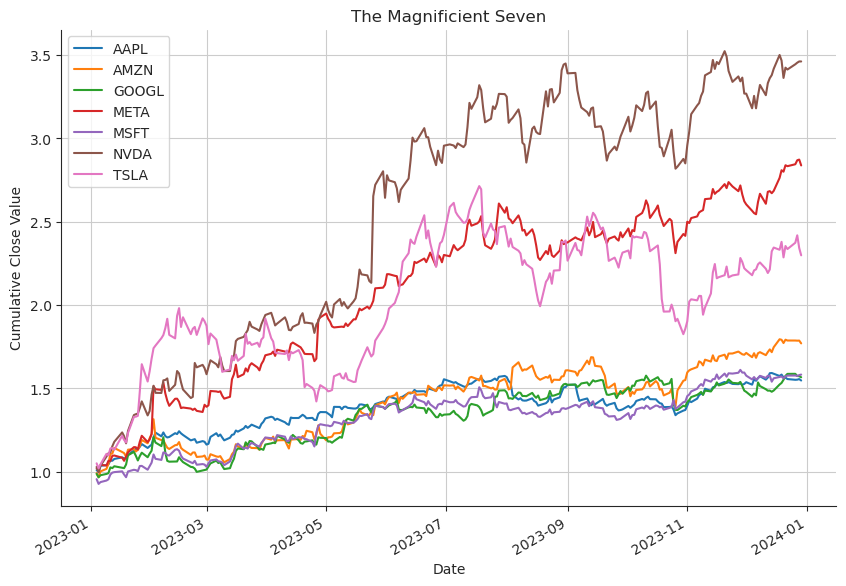

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn to set the style.
sns.set_style('ticks')

# Plot all the close prices as cumulutive closing values.
((pt.pct_change()+1).cumprod()).plot(figsize=(10, 7))
plt.legend()
plt.title('The Magnificient Seven')

# Define the labels
plt.ylabel('Cumulative Close Value')
plt.xlabel('Date')

# Plot the grid lines
plt.grid(True)
sns.despine()
plt.show()

In [25]:
import boto3

# Set your MinIO endpoint and credentials
minio_endpoint = "http://localhost:9090"
access_key = 'Is4MNdgVpvEwHeNn'
secret_key =  'zX2cFDClAIfl8Ecbz96I2J9QGTLUjaEs'

# Initialize the S3 client
s3_client = boto3.client('s3', endpoint_url=minio_endpoint, aws_access_key_id=access_key, aws_secret_access_key=secret_key)

# Upload an object to a bucket
bucket_name = 'your-bucket-name'
object_key = 'your-object-key'
local_file = 'marketdata/AAPL.parquet'

s3_client.upload_file(local_file, bucket_name, object_key)

ResponseParserError: Unable to parse response (syntax error: line 1, column 0), invalid XML received. Further retries may succeed:
b'<!doctype html><html lang="en"><head><meta charset="utf-8"/><base href="/"/><meta content="width=device-width,initial-scale=1" name="viewport"/><meta content="#081C42" media="(prefers-color-scheme: light)" name="theme-color"/><meta content="#081C42" media="(prefers-color-scheme: dark)" name="theme-color"/><meta content="MinIO Console" name="description"/><meta name="minio-license" content="agpl" /><link href="./styles/root-styles.css" rel="stylesheet"/><link href="./apple-icon-180x180.png" rel="apple-touch-icon" sizes="180x180"/><link href="./favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/><link href="./favicon-96x96.png" rel="icon" sizes="96x96" type="image/png"/><link href="./favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/><link href="./manifest.json" rel="manifest"/><link color="#3a4e54" href="./safari-pinned-tab.svg" rel="mask-icon"/><title>MinIO Operator</title><script defer="defer" src="./static/js/main.450ec5c0.js"></script><link href="./static/css/main.110caa22.css" rel="stylesheet"></head><body><noscript>You need to enable JavaScript to run this app.</noscript><div id="root"><div id="preload"><img src="./images/background.svg"/> <img src="./images/background-wave-orig2.svg"/></div><div id="loader-block"><img src="./Loader.svg"/></div></div></body></html>'

In [22]:
!pip install boto3 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 33.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.51
    Uninstalling botocore-1.34.51:
      Successfully uninstalled botocore-1.34.51
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.1 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.34.62 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
